In [1]:
import pyedflib
import matplotlib.pyplot as plt
from pathlib import Path
import os
import numpy as np
from scipy.signal import butter, iirnotch, filtfilt, lfilter

In [2]:
class EDFFile:
    def __init__(self, file: Path):
        self.file_path = file.absolute().as_posix()
        self.file_name = file.name
        self.file_handle = None
        self.signal_headers = None
        self.sample_frequency = None
        self.raw_signals = []
        self.filtered_signals = []
        self.annotations = []
        
    def load_raw_signals(self):
        if self.file_handle is None:
            self.file_handle = pyedflib.EdfReader(self.file_path)
            
        num_signals = self.file_handle.signals_in_file
        
        for i in range(num_signals):
            signal_buffer = self.file_handle.readSignal(i)
            self.raw_signals.append(signal_buffer)
    
    def load_signal_headers(self):
        if self.file_handle is None:
            self.file_handle = pyedflib.EdfReader(self.file_path)

        self.signal_headers = self.file_handle.getSignalHeaders()

    def load_annotations(self):
        if self.file_handle is None:
            self.file_handle = pyedflib.EdfReader(self.file_path)
        
        self.annotations = self.file_handle.readAnnotations()

    def load_sample_frequency(self):
        if self.file_handle is None:
            self.file_handle = pyedflib.EdfReader(self.file_path)
        
        self.sample_frequency = self.file_handle.getSampleFrequencies()[0]
    
    def filter_signals(self, payload:dict, signal_labels=['BI', 'Atmung/Respiration']):
        signals = filter(lambda l : l[0]["label"].split()[0] in signal_labels, 
                         zip(self.signal_headers, self.raw_signals))
        
        filtered = [payload["function"](signal, headers["sample_rate"], payload["cutoff"], payload["order"], payload["f_type"])
                for headers, signal in signals]  # Make it kwargs
        
        self.filtered_signals = filtered
        
        return filtered
        
    def close(self):
        if self.file_handle is not None:
            self.file_handle.close()
            self.file_handle = None

In [3]:
def butterworth_filter(signal, fs, cutoff, order:int=3, f_type='low'):
    nyquist = 0.5 * fs
    normalized_cutoff = cutoff / nyquist
    
    b, a = butter(order, normalized_cutoff, btype=f_type, analog=False)
    
    return filtfilt(b, a, signal)

In [4]:
def notch_filter(signal, fs, frequencies=[50, 100, 150]):
    # Design the notch filter
    Q = 30  # Quality factor
    b, a = iirnotch(frequencies, Q, fs)

    # Apply the notch filter to the signal
    filtered_signal = lfilter(b, a, signal)
    
    return filtfilt(b, a, signal)

In [5]:
def read_files_from_dir(directory: Path):
    extensions = ["edf", "bdf"]

    return [EDFFile(Path(file)) for file in os.scandir(directory) 
            if file.is_file() and file.name.endswith(tuple(extensions))]

In [6]:
directory = Path("data/edf/")
files = read_files_from_dir(directory)

# Dict to specify which functions to apply to the signals
payload={"function": butterworth_filter, "order": 3, "cutoff": 15, "f_type": "low"}

for signal_file in files:
    signal_file.load_raw_signals()
    signal_file.load_signal_headers()
    signal_file.load_annotations()
    signal_file.load_sample_frequency()
    signal_file.filter_signals(payload)

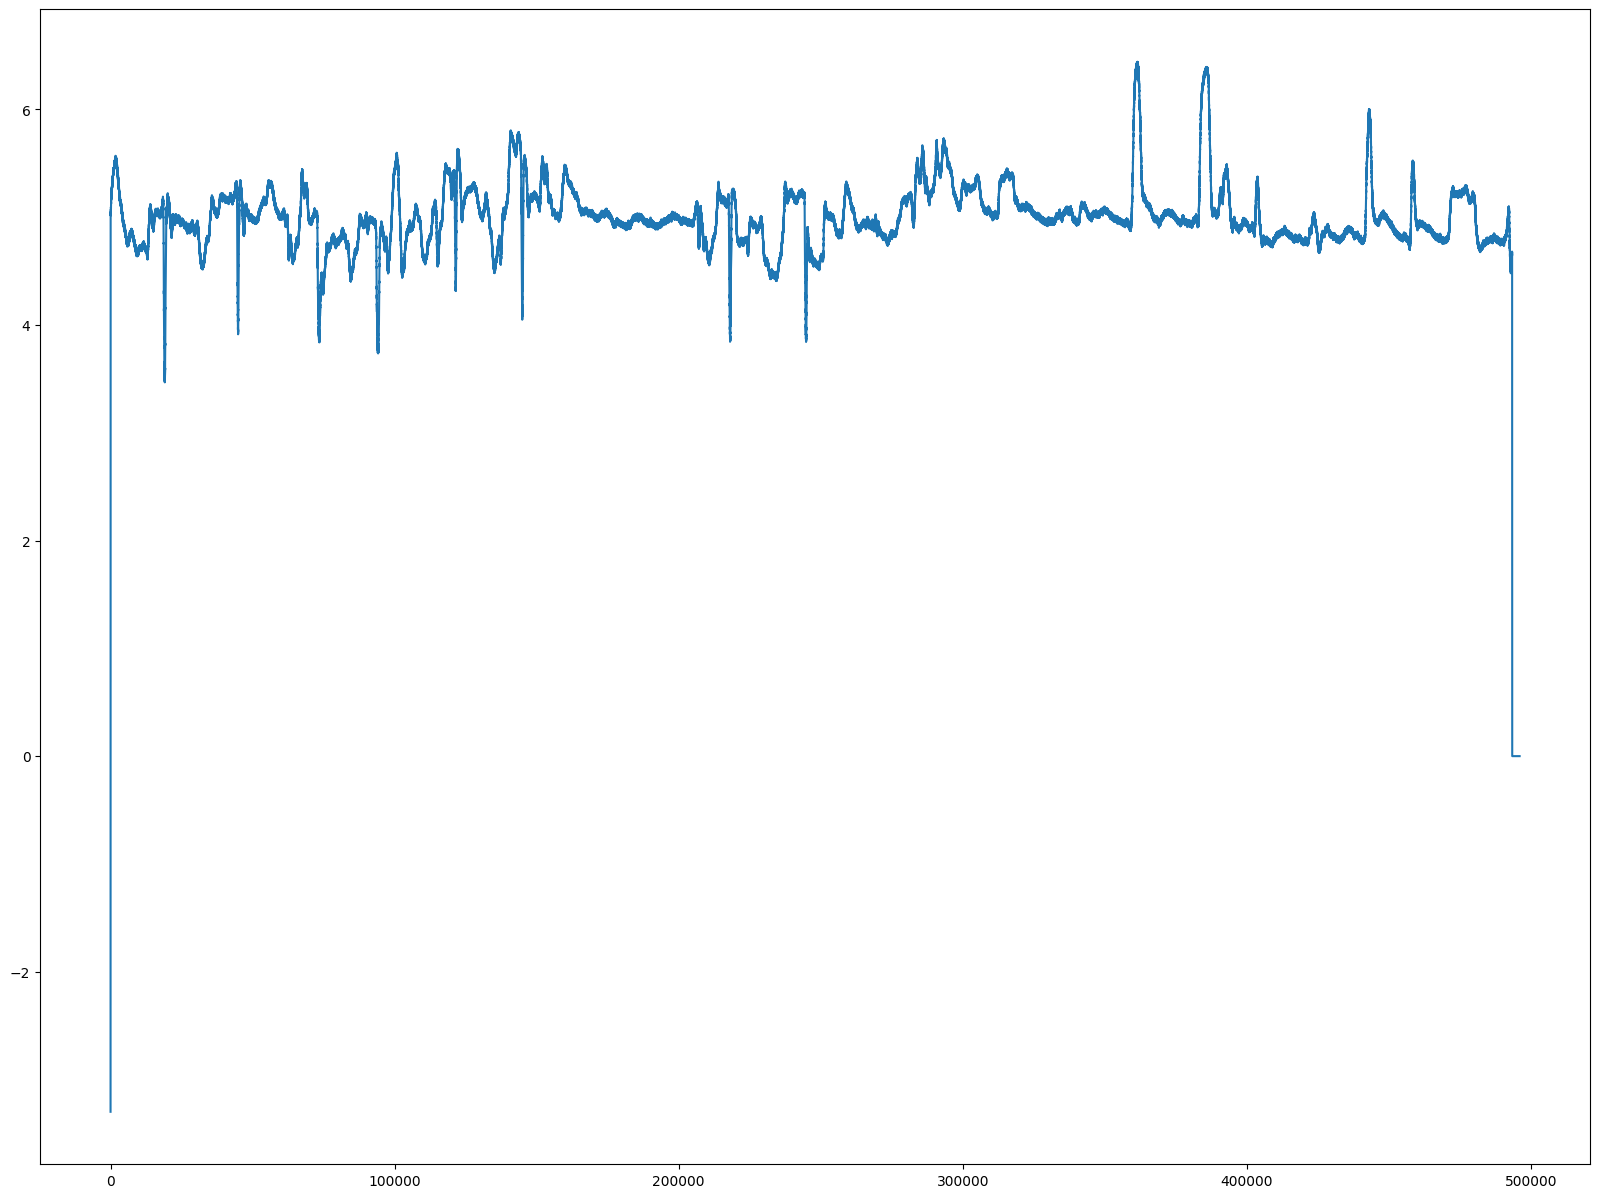

In [8]:
plt.plot(files[0].raw_signals[2])

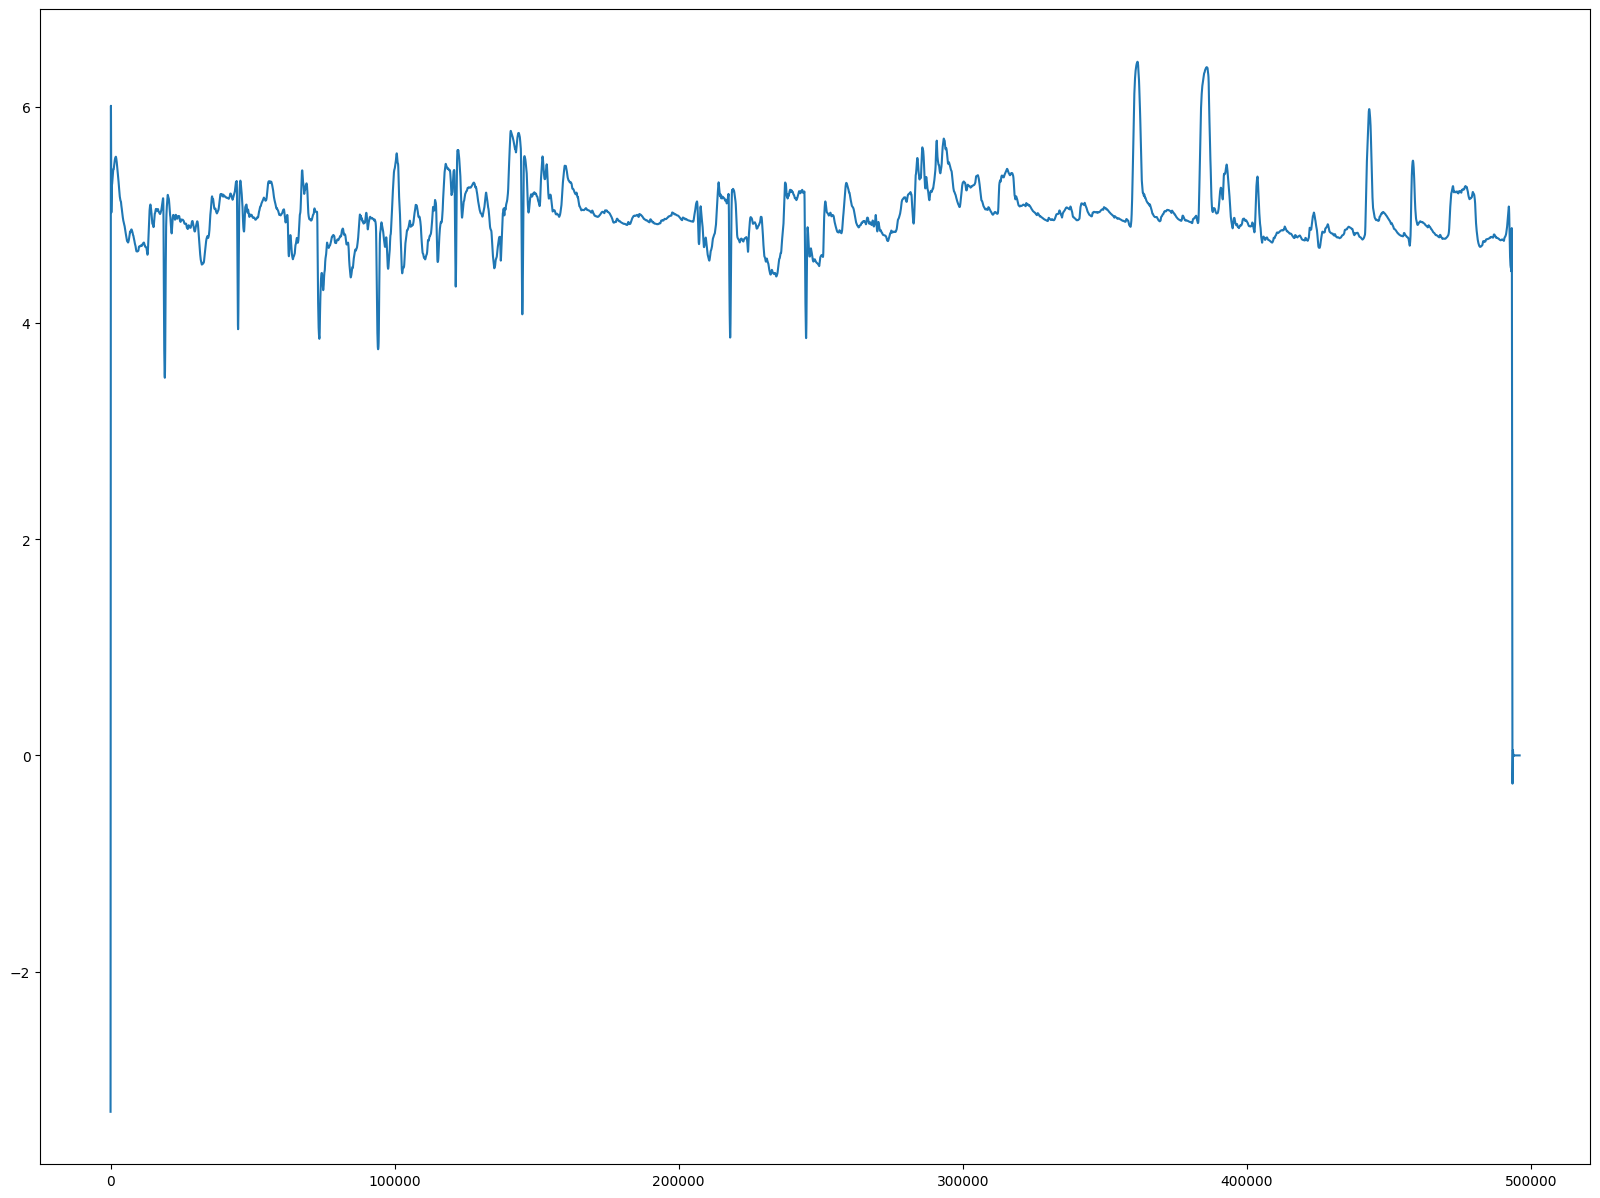

In [9]:
plt.plot(files[0].filtered_signals[0])

In [ ]:
for file in files:
    file.close()

## Save EDF file file.name + _filtered.edf

In [ ]:
from pyedflib import highlevel

# write an edf file
signals = []
channel_names = []

for channel_name, signal, fs in self.filtered_signals:
    channel_names.append(channel_name)
    signals.append(signal)

signal_headers = highlevel.make_signal_headers(channel_names, sample_frequency=fs)

header = highlevel.make_header(patientname='patient', gender='Female')

if highlevel.write_edf(f'{self.file_name}_filtered.edf', signals, signal_headers, header):
    print("The file has been successfully saved.")
else:
    print("Something went wrong with the saving process.")

In [ ]:
t = EDFFile(f'{self.file_name}_filtered.edf')

In [ ]:
plt.plot(t.signals[2][1])

## Questions:

- How should the signals be saved in the class for better performance?
- What is the best way to communicate between the front and the back end? Should I write json files to the front-end?
- Is it recommended to receive the requested parameters from the front-end as a dictionary as illustrated in the "payload" variable?